# Lesson 9: Latent Models

*Teachers:* Fares Schulz, Lina Campanella

In this course we will cover:
1. Gaussian Mixture Models
2. EM Algorithm

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.distributions as distribution
import seaborn as sns
import torch
from torch.utils.data import random_split

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

## Create data

We begin by generating a synthetic dataset with 4 clusters using `make_blobs` from scikit-learn. The data points are scattered across two features, forming distinct groups that we'll try to model using latent variables. But for now we don't know how to classify the points in the best way yet.

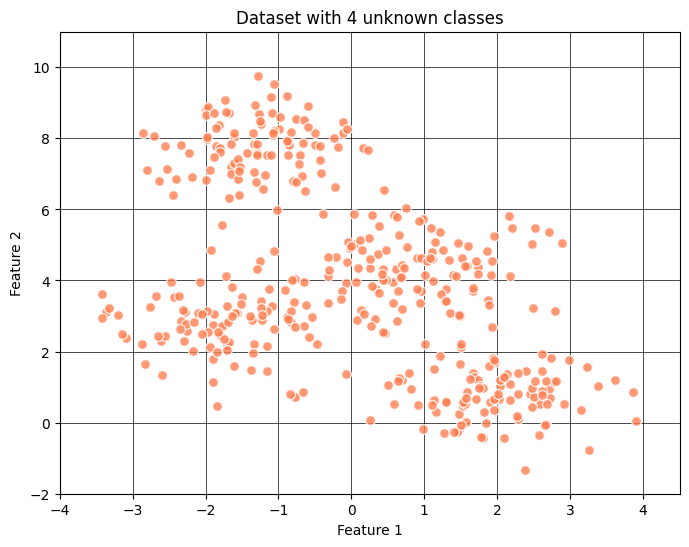

In [45]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=400, centers=4, cluster_std=0.80, random_state=0)

fig, ax = plt.subplots(figsize=(8, 6))  # ✅ Better
ax.scatter(X[:, 0], X[:, 1], c='coral', s=50, edgecolor='w', alpha=0.8, zorder=2)
ax.grid(color='black', linewidth=0.5)
ax.set_title('Dataset with 4 unknown classes', color='black')
ax.set_xlabel('Feature 1', color='black')
ax.set_ylabel('Feature 2', color='black')
ax.tick_params(colors='black')
ax.set_xlim(-4, 4.5)
ax.set_ylim(-2, 11)
plt.show()

## Fitting with a simple Gaussian

We can try to fit the data with one gaussian distribution, but this won't give us a lot of insight, since we actually want to classify the data into 4 clusters. A single Gaussian distribution is insufficient for modeling multi-cluster data. 

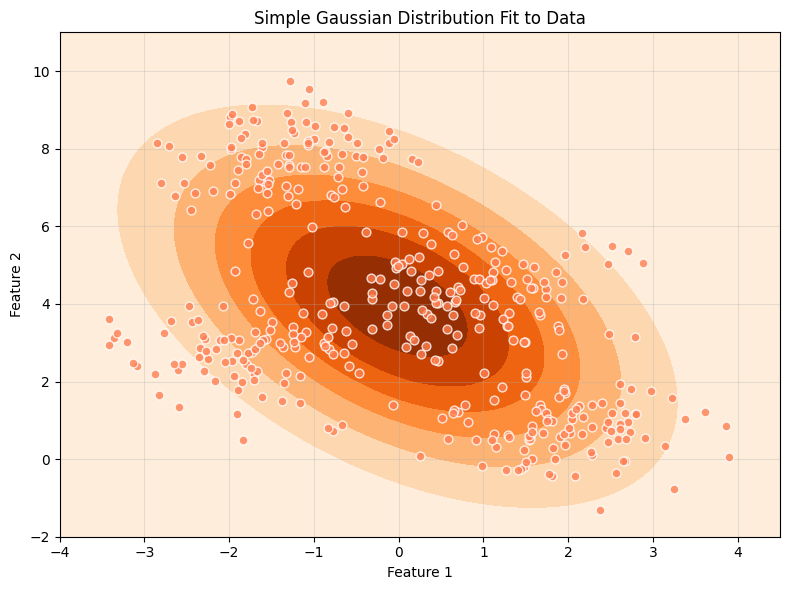

In [3]:
from scipy.stats import multivariate_normal

# Manually compute mean and covariance
mu = X.mean(axis=0)
sigma = np.cov(X.T)

# Create grid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                     np.linspace(y_min, y_max, 100))

# Compute Gaussian PDF on grid
pos = np.dstack((xx, yy))
rv = multivariate_normal(mu, sigma)
z = rv.pdf(pos)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.scatter(X[:, 0], X[:, 1], c='coral', s=40, edgecolor='w', alpha=0.8, zorder=2)
ax.contourf(xx, yy, z, cmap='Oranges', alpha=1)
ax.grid(alpha=0.3)
ax.set_title('Simple Gaussian Distribution Fit to Data', color='black')
ax.set_xlabel('Feature 1', color='black')
ax.set_ylabel('Feature 2', color='black')
ax.tick_params(colors='black')
ax.set_xlim(-4, 4.5)
ax.set_ylim(-2, 11)
fig.tight_layout()


By fitting one multivariate Gaussian to the entire dataset and visualizing its probability density function as a contour plot, we can see that it fails to capture the distinct clusters. The single Gaussian averages over all clusters, resulting in a poor representation of the data's true structure.

## Gaussian mixture models

The solution is to use multiple gaussian distributions to model complex data. Each Gaussian component can capture one cluster. First we have to initialize 4 gaussian distributions and then we have to optimize the mean and the variance of these distributions to correctly fit the clusters. The good thing about GMMs is that they allow for distribution functions to be shaped elliptical (with K-Means, this is not possible).

Step 0: Random Initialization


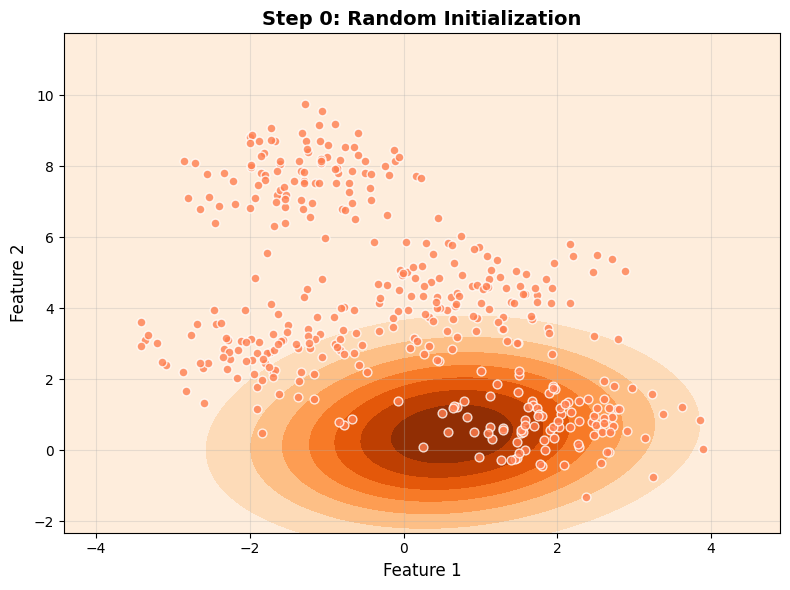

In [4]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def plot_gmm_step(X, means, covariances, weights, responsibilities=None, title="", classes=False):
    """
    Visualize GMM components and optionally responsibilities
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create grid for plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    pos = np.dstack((xx, yy))
    
    # # Compute mixture PDF
    z = np.zeros_like(xx)
    
    for k in range(len(means)):
        rv = multivariate_normal(means[k], covariances[k])
        z += weights[k] * rv.pdf(pos)
    
    colors = ['gold', 'darkorange', 'orangered', 'red']

    if classes is True:
        labels = np.argmax(responsibilities, axis=1)
        # Scatter plot each cluster with size based on responsibility
        for i in range(len(means)): 
            mask = labels == i
            size = 50 * (responsibilities[mask, :].max(1) ** 2)
            ax.scatter(X[mask, 0], X[mask, 1], c=colors[i], s=size, edgecolor='w', alpha=0.8, label=f'Class {i+1}', zorder=3)
    else:
        ax.scatter(X[:, 0], X[:, 1], c='coral', s=40, 
                    edgecolor='w', alpha=0.8, zorder=3)
    
    # Plot contours
    ax.contourf(xx, yy, z, cmap='Oranges', alpha=1)
    ax.set_xlabel('Feature 1', fontsize=12)
    ax.set_ylabel('Feature 2', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    fig.tight_layout()


# Initialize GMM parameters randomly
np.random.seed(42)
n_components = 4

# Random initialization (poor fit initially)
initial_means = np.random.randn(n_components, 2) 
initial_covariances = np.array([np.eye(2) * 2 for _ in range(n_components)])
initial_weights = np.ones(n_components) / n_components

print("Step 0: Random Initialization")
plot_gmm_step(X, initial_means, initial_covariances, initial_weights, 
              title="Step 0: Random Initialization")

## Optimizing the GMM with EM-Algorithm
The Expectation-Maximization (EM) algorithm is an iterative method used to find maximum likelihood estimates of parameters in statistical models, particularly when the model depends on unobserved latent variables. In the context of Gaussian Mixture Models (GMMs), the EM algorithm helps optimize the parameters of the Gaussian components to best fit the data.

### E-step
In the E-step (Expectation step), we compute the expected value of the latent variables given the current estimates of the parameters. For GMMs, this involves calculating the responsibilities, which represent the probability that each data point belongs to each Gaussian component. The responsibilities are computed using Bayes' theorem, taking into account the current means, covariances, and mixture weights of the Gaussian components.

$$
\gamma_{ik} = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}


Step 1: E-step - Assign points to clusters (soft assignment)


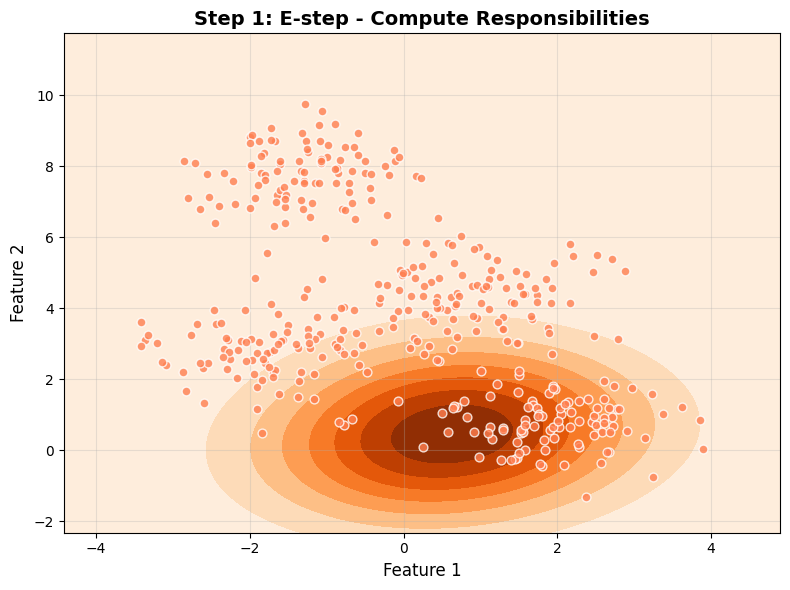

In [ ]:
def e_step(X, means, covariances, weights):
    """
    Expectation step: compute responsibilities (soft assignments)
    """
    N = X.shape[0] # number of data points
    K = len(means) # number of components
    responsibilities = np.zeros((N, K))
    
    # Compute probability of each point under each component
    for k in range(K):
        rv = multivariate_normal(means[k], covariances[k])
        responsibilities[:, k] = weights[k] * rv.pdf(X)
    
    # Normalize to get responsibilities (posterior probabilities)
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    
    return responsibilities

# Run E-step
responsibilities = e_step(X, initial_means, initial_covariances, initial_weights)

print("\nStep 1: E-step - Assign points to clusters (soft assignment)")
plot_gmm_step(X, initial_means, initial_covariances, initial_weights, 
              responsibilities, 
              title="Step 1: E-step - Compute Responsibilities")

### M-step
In the M-step (Maximization step), we update the parameters of the Gaussian components to maximize the expected log-likelihood found in the E-step. This involves recalculating the means, covariances, and mixture weights based on the responsibilities computed in the E-step.

$$
\begin{aligned}
N_k &= \sum_{i=1}^{N} \gamma_{ik} \\
\mu_k &= \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} x_i \\
\Sigma_k &= \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T \\
\pi_k &= \frac{N_k}{N}
\end{aligned}
$$


Step 2: M-step - Update parameters based on responsibilities


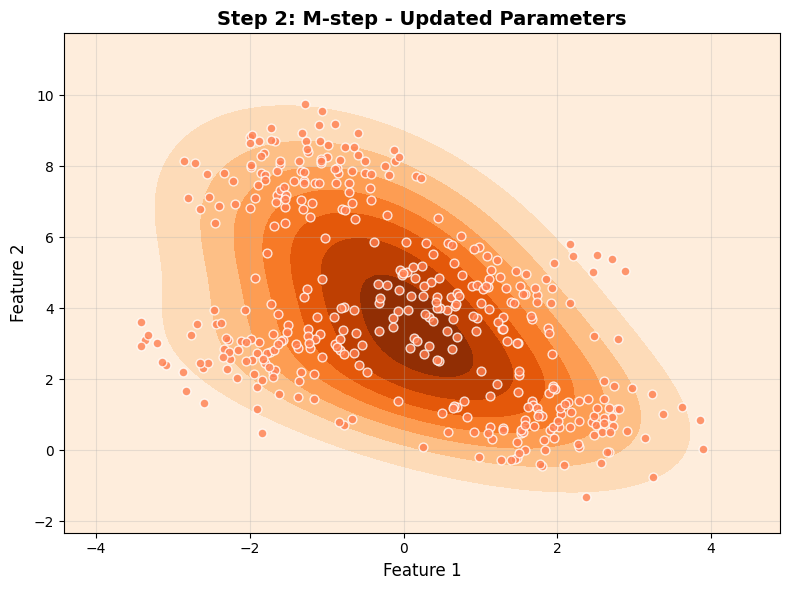

In [ ]:
def m_step(X, responsibilities):
    """
    Maximization step: update means, covariances, and weights
    """
    N, d = X.shape # number of data points and dimensions
    K = responsibilities.shape[1] # number of components
    
    # Effective number of points assigned to each component
    Nk = responsibilities.sum(axis=0)
    
    # Update weights
    weights = Nk / N
    
    # Update means
    means = np.zeros((K, d))
    for k in range(K):
        means[k] = (responsibilities[:, k:k+1] * X).sum(axis=0) / Nk[k]
    
    # Update covariances
    covariances = np.zeros((K, d, d))
    for k in range(K):
        diff = X - means[k]
        covariances[k] = (responsibilities[:, k:k+1] * diff).T @ diff / Nk[k]
    
    return means, covariances, weights

# Run M-step
new_means, new_covariances, new_weights = m_step(X, responsibilities)

print("\nStep 2: M-step - Update parameters based on responsibilities")
plot_gmm_step(X, new_means, new_covariances, new_weights, 
              responsibilities,
              title="Step 2: M-step - Updated Parameters")

After iterating between the E-step and M-step until convergence, the parameters of the Gaussian components will be optimized to best fit the data, allowing us to effectively model the underlying clusters in the dataset.

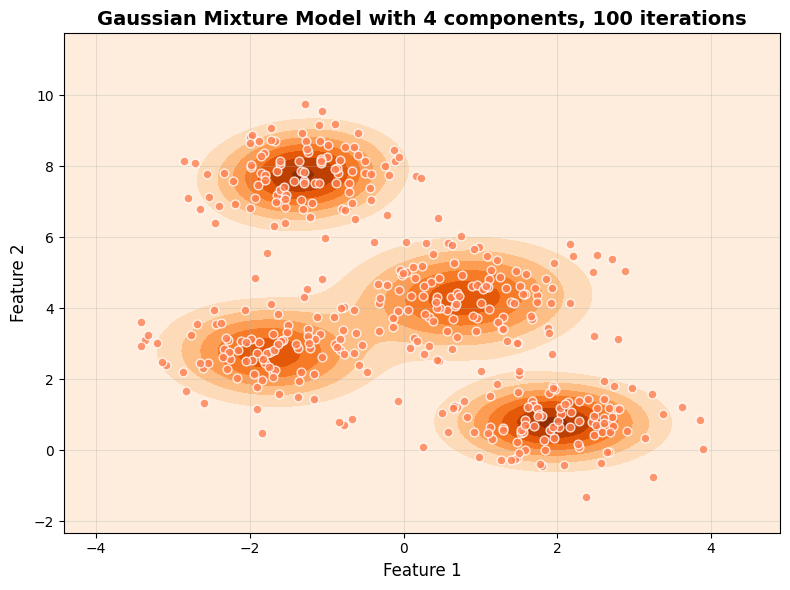

In [7]:
def train_gmm(X, n_iterations=100, means=None, covariances=None, weights=None, classes=False):
    
    for i in range(n_iterations):
        # E-step
        responsibilities = e_step(X, means, covariances, weights)
        
        # M-step
        means, covariances, weights = m_step(X, responsibilities)
        
    plot_gmm_step(X, means, covariances, weights, responsibilities, classes=classes,
                        title=f"Gaussian Mixture Model with {len(means)} components, {i+2} iterations")
            
    return means, covariances, weights

# Train GMM for a few iterations
final_means, final_covariances, final_weights = train_gmm(X, 99, new_means, new_covariances, new_weights, classes=False)

## Predicting the class labels
To predict the class labels for new data points using the fitted Gaussian Mixture Model (GMM), we calculate the probabilties of each data point belonging to each Gaussian component and assign the class based on the highest probability. In this plot the predicted class labels are shown with different colors and sizes. The size of the points indicates the confidence of the prediction, with larger points representing higher confidence.

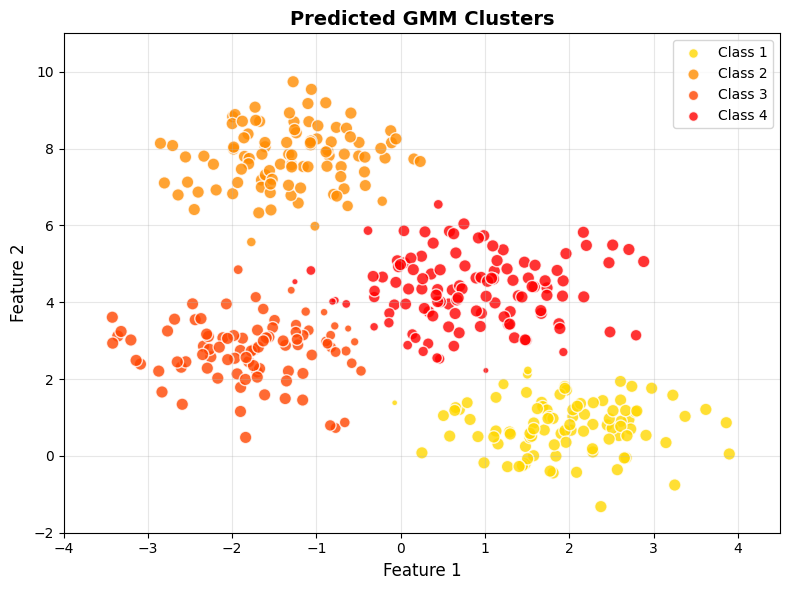

In [8]:
def predict_gmm(X, means, covariances, weights):
    """
    Predict cluster assignments based on highest responsibility
    """
    responsibilities = e_step(X, means, covariances, weights)
    return np.argmax(responsibilities, axis=1), responsibilities

z = np.zeros_like(xx)
colors = ['gold', 'darkorange', 'orangered', 'red' ]

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot each cluster with size based on responsibility
for i in range(4):
    labels, responsibilities = predict_gmm(X, final_means, final_covariances, final_weights)
    mask = labels == i
    size = 80 * (responsibilities[mask, :].max(1) ** 2)
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[i], s=size, edgecolor='w', alpha=0.8, label=f'Class {i+1}')
    
# Plot contours
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Predicted GMM Clusters', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(['Class 1', 'Class 2', 'Class 3', 'Class 4'], loc='upper right')
ax.set_xlim(-4,4.5)
ax.set_ylim(-2,11)
fig.tight_layout()

### Scikit-learn's GaussianMixture function
Now that we have understood how the EM algorithm works to fit a Gaussian Mixture Model (GMM), we can compare it to existing libraries to simplify the implementation. Skit-learn provides a convenient `GaussianMixture` class that encapsulates the EM algorithm for fitting GMMs. 

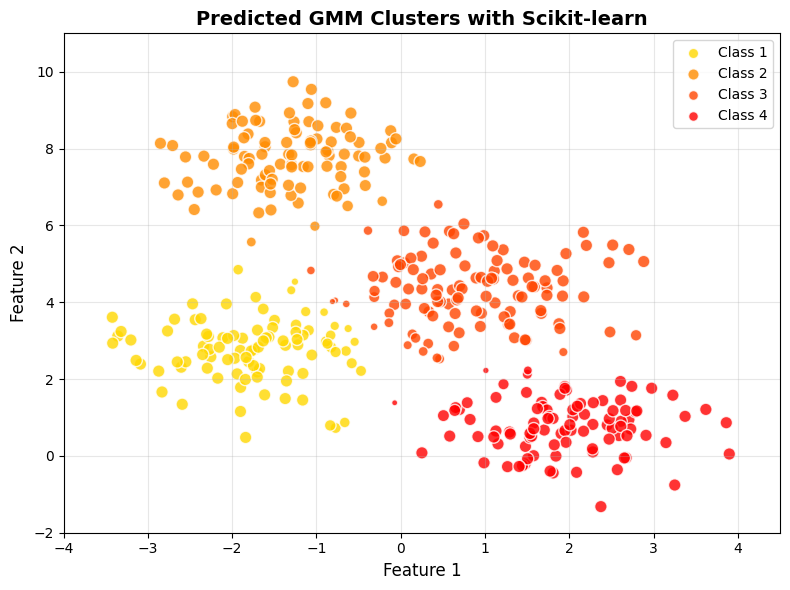

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X) # uses EM algorithm and 100 iterations by default
labels = gmm.predict(X)

colors = ['gold', 'darkorange', 'orangered', 'red' ]

fig, ax = plt.subplots(figsize=(8,6))

for i in range(4):
    mask = labels == i
    responsibilities = gmm.predict_proba(X)
    size = 80 * (responsibilities[mask, :].max(1) ** 2)
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[i], s=size, edgecolor='w', alpha=0.8, label=f'Class {i+1}')

# ax.scatter(X[:, 0], X[:, 1], c=[colors[label] for label in labels], s=40, edgecolor='w', alpha=0.8)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('Predicted GMM Clusters with Scikit-learn', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend( loc='upper right')
ax.set_xlim(-4,4.5)
ax.set_ylim(-2,11)
fig.tight_layout()

### Robustness of GMMs with full covariance matrices

To test the robustness of GMMs, we apply a random linear transformation to stretch and rotate the data. This creates elliptical clusters with different orientations and shapes. Unlike spherical Gaussians with diagonal covariances, GMMs with full covariance matrices can adapt to these elongated clusters, demonstrating the flexibility of the model in capturing various cluster geometries.

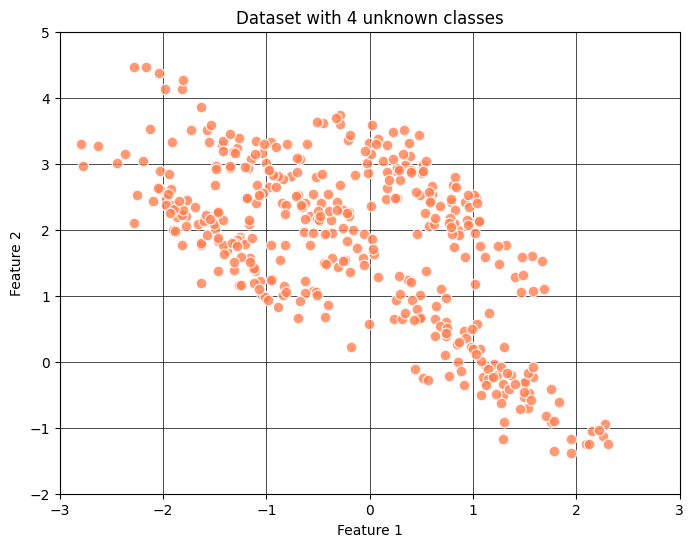

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

fig, ax = plt.subplots(figsize=(8, 6))  # ✅ Better
ax.scatter(X_stretched[:, 0], X_stretched[:, 1], c='coral', s=60, edgecolor='w', alpha=0.8, zorder=2)
ax.grid(color='black', linewidth=0.5)
ax.set_title('Dataset with 4 unknown classes', color='black')
ax.set_xlabel('Feature 1', color='black')
ax.set_ylabel('Feature 2', color='black')
ax.tick_params(colors='black')
ax.set_xlim(-3, 3)
ax.set_ylim(-2, 5)
plt.show()

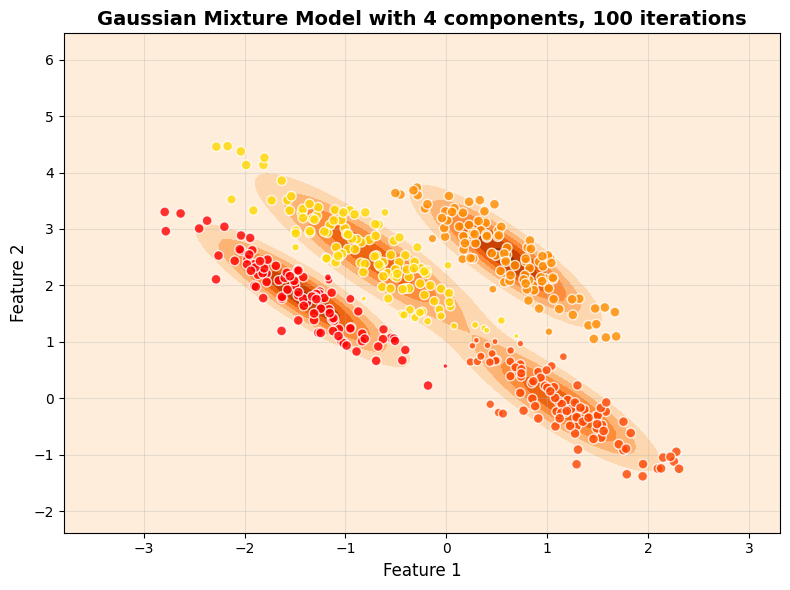

In [11]:
# Train GMM for more elliptical data
np.random.seed(0) 
initial_means = np.random.randn(n_components, 2)
initial_covariances = np.array([np.eye(2) * 3 for _ in range(n_components)])
initial_weights = np.ones(n_components) / n_components

final_means, final_covariances, final_weights = train_gmm(X_stretched, 99, initial_means, initial_covariances, initial_weights, classes=True)

## ELBO

The Evidence Lower Bound (ELBO) is a fundamental concept in variational inference and latent variable models. It provides a lower bound on the log-likelihood of the data and consists of two terms: the expected log-likelihood under the posterior and the KL divergence between the approximate and true posterior. In this exercise the ELBO is maximized during the EM algorithm to optimize the parameters of the Gaussian Mixture Model (GMM). The E-step minimizes the KL divergence by updating the responsibilities, while the M-step maximizes the expected log-likelihood by updating the model parameters. Monitoring the ELBO over iterations helps ensure convergence and assess model fit.

$$
\begin{aligned}
ELBO &= \mathbb{E}_{q(z|x)}[\log p(x, z|\Theta)] - \mathbb{E}_{q(z|x)}[\log q(z|x)] \\
&= \log p(x|\Theta) - D_{KL}(q(z|x) || p(z|x,\Theta))
\end{aligned}
$$

### KL Divergence Derivation

The KL divergence between our approximate posterior $q(z|x)$ and the true posterior $p(z|x)$ is defined as:

$$
D_{KL}(q(z|x) || p(z|x)) = \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z|x)}\right]
$$

For a Gaussian Mixture Model, we expand this for each data point $x_i$ and component $k$:

$$
\begin{aligned}
D_{KL}(q(z|x) || p(z|x)) &= \sum_{i=1}^{N} \sum_{k=1}^{K} q(z_i = k) \log \frac{q(z_i = k)}{p(z_i = k | x_i, \theta)} \\
&= \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{ik} \log \frac{\gamma_{ik}}{p(z_i = k | x_i, \theta)}
\end{aligned}
$$

where $\gamma_{ik} = q(z_i = k)$ are the responsibilities computed in the E-step.

Using Bayes' rule, the true posterior is:

$$
p(z_i = k | x_i, \theta) = \frac{p(x_i | z_i = k, \theta) \cdot p(z_i = k)}{\sum_{j=1}^{K} p(x_i | z_i = j, \theta) \cdot p(z_i = j)} = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}
$$

where $\pi_k$ are the mixture weights, $\mu_k$ are the means, and $\Sigma_k$ are the covariances.

Substituting this into the KL divergence formula:

$$
D_{KL}(q(z) || p(z|x)) = \sum_{i=1}^{N} \sum_{k=1}^{K} \gamma_{ik} \left(\log \gamma_{ik} - \log \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}\right)
$$


In [41]:
# Generate single-cluster data
X, _ = make_blobs(n_samples=400, centers=4, cluster_std=1.0, random_state=42)

# Fit with single Gaussian (no latent variables needed!)
n_components = 2
initial_means = np.array([[0.0, 0.0]])
initial_covariances = np.array([np.eye(2)])
initial_weights = np.array([1.0])

Initial means:
 [[ 0.49671415 -0.1382643 ]]


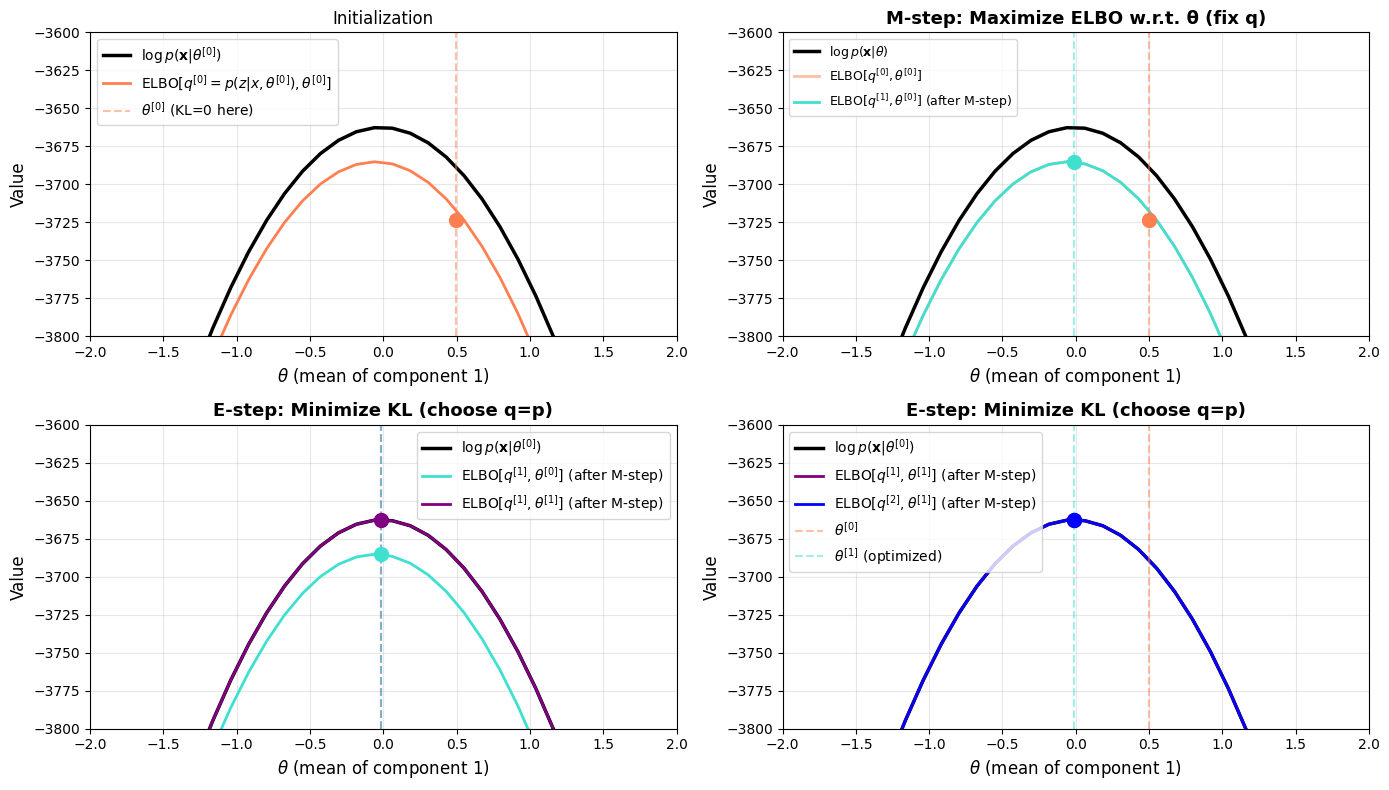

In [71]:
# Elbo = log(p(x|theta))-D_KL(q(z)||p(z|x,theta))
def log_likelihood(X, means, covariances, weights):
    """Compute log-likelihood of data under GMM"""
    N = X.shape[0]
    log_likelihood = 0
    
    for i in range(N):
        prob = 0
        for k in range(len(means)):
            rv = multivariate_normal(means[k], covariances[k])
            prob += weights[k] * rv.pdf(X[i])
        log_likelihood += np.log(prob)
    
    return log_likelihood



def compute_elbo(X, means, covariances, weights, responsibilities, ll):
    """
    Compute ELBO as: log p(x|θ) - KL(q||p)
    More intuitive decomposition!
    """
    N = X.shape[0]
    
    
    # 2. Compute KL divergence: KL(q(z) || p(z|x,θ))
    kl_div = 0
    
    for i in range(N):
        denominator = 0
        for j in range(len(means)):
            rv_j = multivariate_normal(means[j], covariances[j])
            denominator += weights[j] * rv_j.pdf(X[i])
            
        for k in range(len(means)):
            if responsibilities[i, k] > 1e-10:
                # q(z_i = k)
                q_z = responsibilities[i, k]
                
                # p(z_i = k | x_i, θ) using Bayes rule
                rv = multivariate_normal(means[k], covariances[k])
                numerator = weights[k] * rv.pdf(X[i])
                
                # Denominator: sum over all components
                p_z_given_x = numerator / (denominator + 1e-10)
                
                # KL divergence: sum_z q(z) log(q(z) / p(z|x))
                if p_z_given_x > 1e-10:
                    kl_div += q_z * (np.log(q_z) - np.log(p_z_given_x))
    
    # ELBO = log p(x|θ) - KL(q||p)
    elbo = ll - kl_div
    
    return elbo, ll, kl_div


# Visualization: sweep over mean of first component
np.random.seed(42)
n_components = 1
initial_means = np.random.randn(n_components,2) 
print("Initial means:\n", initial_means)
initial_covariances = np.array([np.eye(2) * 2 for _ in range(n_components)])
initial_weights = np.ones(n_components) / n_components

# Run one E-step and one M-step
responsibilities_0 = e_step(X, initial_means, initial_covariances, initial_weights)
means_1, covariances_1, weights_1 = m_step(X, responsibilities_0)
responsibilities_1 = e_step(X, means_1, covariances_1, weights_1)
means_2, covariances_2, weights_2 = m_step(X, responsibilities_1)
responsibilities_2 = e_step(X, means_2, covariances_2, weights_2)
means_3, covariances_3, weights_3 = m_step(X, responsibilities_2)

# Sweep mean of first component along x-axis
mean_range = np.linspace(-3, 3, 50)
log_likelihoods_0 = []
log_likelihoods_1 = []
elbos_0 = []
elbos_1 = []
elbos_2 = []
elbos_3 = []

for mean_val in mean_range:
    # Test with varying first component mean
    test_means_0 = initial_means.copy()
    test_means_0[0, 0] = mean_val
    # print(f'means val = {test_means_0}')

    
    test_means_1 = means_1.copy()
    test_means_1[0, 0] = mean_val

    test_means_2 = means_2.copy()
    test_means_2[0, 0] = mean_val
    
    # Compute log-likelihood for EACH parameter set
    ll_0 = log_likelihood(X, test_means_0, initial_covariances, initial_weights)
    log_likelihoods_0.append(ll_0)
    
    # ELBO after E-step 0: tight bound at θ^[0] (KL=0 at initial_means[0,0])
    elbo_0, _, _= compute_elbo(X, test_means_0, initial_covariances, initial_weights, responsibilities_0, ll_0)
    elbos_0.append(elbo_0)
    
    # ELBO after M-step 1 but keeping q^[0] fixed (shows how ELBO varies when we change θ but keep q fixed)
    elbo_1, _, _= compute_elbo(X, test_means_0, initial_covariances, initial_weights, responsibilities_1, ll_0)
    elbos_1.append(elbo_1)
    
    # ELBO after E-step 1: update q to make bound tight again at new θ^[1]
    elbo_2, _, _= compute_elbo(X, test_means_1, covariances_1, weights_1, responsibilities_1, ll_0)
    elbos_2.append(elbo_2)

    elbo_3, _, _= compute_elbo(X, test_means_1, covariances_1, weights_1, responsibilities_2, ll_0)
    elbos_3.append(elbo_3)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))

# Left plot: E-step - minimize KL divergence (ELBO touches log-likelihood)
ax1.plot(mean_range, log_likelihoods_0, 'k-', linewidth=2.5, label=r'$\log p(\mathbf{x}|\theta^{[0]})$')
ax1.plot(mean_range, elbos_0, 'coral', linewidth=2, label=r'ELBO[$q^{[0]}=p(z|x,\theta^{[0]}), \theta^{[0]}$]')
ax1.axvline(initial_means[0, 0], color='coral', linestyle='--', alpha=0.5, label=r'$\theta^{[0]}$ (KL=0 here)')
ax1.scatter([initial_means[0, 0]], [elbos_0[np.argmin(np.abs(mean_range - initial_means[0, 0]))]], 
           color='coral', s=100, zorder=5)
ax1.set_xlabel(r'$\theta$ (mean of component 1)', fontsize=12)
ax1.set_ylabel(r'Value', fontsize=12)
ax1.set_title('Initialization')
ax1.set_ylim(-3800,-3600)
ax1.set_xlim(-2,2)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Right plot: M-step - maximize ELBO w.r.t. θ (keeping q fixed)
ax2.plot(mean_range, log_likelihoods_0, 'k-', linewidth=2.5, label=r'$\log p(\mathbf{x}|\theta)$')
ax2.plot(mean_range, elbos_0, 'coral', linewidth=2, alpha=0.5, label=r'ELBO[$q^{[0]}, \theta^{[0]}$]')
ax2.plot(mean_range, elbos_1, 'turquoise', linewidth=2, label=r'ELBO[$q^{[1]}, \theta^{[0]}$] (after M-step)')
ax2.axvline(initial_means[0, 0], color='coral', linestyle='--', alpha=0.5)
ax2.axvline(means_1[0, 0], color='turquoise', linestyle='--', alpha=0.5)
ax2.scatter([initial_means[0, 0]], [elbos_0[np.argmin(np.abs(mean_range - initial_means[0, 0]))]], color='coral', s=100, zorder=5)
ax2.scatter([means_1[0, 0]], [elbos_1[np.argmin(np.abs(mean_range - means_1[0, 0]))]], color='turquoise', s=100, zorder=5)
ax2.set_xlabel(r'$\theta$ (mean of component 1)', fontsize=12)
ax2.set_ylabel(r'Value', fontsize=12)
ax2.set_title('M-step: Maximize ELBO w.r.t. θ (fix q)', fontsize=13, fontweight='bold')
ax2.set_ylim(-3800,-3600)
ax2.set_xlim(-2,2)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

ax3.plot(mean_range, log_likelihoods_0, 'k-', linewidth=2.5, label=r'$\log p(\mathbf{x}|\theta^{[0]})$')
# ax3.plot(mean_range, elbos_0, 'coral', linewidth=2, label=r'ELBO[$q^{[0]}=p(z|x,\theta^{[0]}), \theta^{[0]}$]')
ax3.plot(mean_range, elbos_1, 'turquoise', linewidth=2, label=r'ELBO[$q^{[1]}, \theta^{[0]}$] (after M-step)')
ax3.plot(mean_range, elbos_2, 'purple', linewidth=2, label=r'ELBO[$q^{[1]}, \theta^{[1]}$] (after M-step)')
ax3.axvline(means_2[0, 0], color='purple', linestyle='--', alpha=0.5)
ax3.axvline(means_1[0, 0], color='turquoise', linestyle='--', alpha=0.5)
ax3.scatter([means_1[0, 0]], [elbos_1[np.argmin(np.abs(mean_range - means_1[0, 0]))]], color='turquoise', s=100, zorder=5)
ax3.scatter([means_2[0, 0]], [elbos_2[np.argmin(np.abs(mean_range - means_2[0, 0]))]], color='purple', s=100, zorder=5)
ax3.set_xlabel(r'$\theta$ (mean of component 1)', fontsize=12)
ax3.set_ylabel(r'Value', fontsize=12)
ax3.set_title('E-step: Minimize KL (choose q=p)', fontsize=13, fontweight='bold')
ax3.set_ylim(-3800,-3600)
ax3.set_xlim(-2,2)
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

ax4.plot(mean_range, log_likelihoods_0, 'k-', linewidth=2.5, label=r'$\log p(\mathbf{x}|\theta^{[0]})$')
ax4.plot(mean_range, elbos_2, 'purple', linewidth=2, label=r'ELBO[$q^{[1]}, \theta^{[1]}$] (after M-step)')
ax4.plot(mean_range, elbos_3, 'blue', linewidth=2, label=r'ELBO[$q^{[2]}, \theta^{[1]}$] (after M-step)')
ax4.axvline(initial_means[0, 0], color='coral', linestyle='--', alpha=0.5, label=r'$\theta^{[0]}$')
ax4.axvline(means_1[0, 0], color='turquoise', linestyle='--', alpha=0.5, label=r'$\theta^{[1]}$ (optimized)')
ax4.scatter([means_1[0, 0]], [elbos_2[np.argmin(np.abs(mean_range - means_1[0, 0]))]], color='purple', s=100, zorder=5)
ax4.scatter([means_2[0, 0]], [elbos_3[np.argmin(np.abs(mean_range - means_2[0, 0]))]], color='blue', s=100, zorder=5)
ax4.set_xlabel(r'$\theta$ (mean of component 1)', fontsize=12)
ax4.set_ylabel(r'Value', fontsize=12)
ax4.set_title('E-step: Minimize KL (choose q=p)', fontsize=13, fontweight='bold')
ax4.set_ylim(-3800,-3600)
ax4.set_xlim(-2,2)
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3)

fig.tight_layout()